#### Importing and cleaning dataset

In [2]:
import pandas as pd
import keras
import numpy as np
import os

#Get relative directory to find path
path = os.path.join(os.getcwd(), 'data', 'response_format_cleaned_ds1.csv')
responses = pd.read_csv(path, sep=';', header=0)
responses.drop(responses.columns[[0]], axis=1, inplace=True)
responses.head()


Using TensorFlow backend.


,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,sequence1,seqOne,Dep5words[Word1],...,wor_all_selected,wor_all_selected1,minidep_scale,minidep_diagnose,depression_episodes,miniGAD_scale,miniGAD_symptoms_scale,miniGAD_diagnose,minidiagnose_category,minidiagnose_category_number
0,434.0,2020-08-07 11:46:22,15.0,en,6.593644e+08,2020-08-07 11:38:22,2020-08-07 11:46:22,2.0,1.0,motivated,...,NA NA happy NA NA NA NA NA NA NA NA NA NA care...,happy carefree satisfied ...,0.0,0,0,0,0,0,NoDi,0
1,184.0,2020-08-07 11:58:36,15.0,en,2.803892e+08,2020-08-07 11:34:31,2020-08-07 11:58:36,2.0,1.0,connected,...,anxious NA NA NA NA NA NA NA NA NA NA tense NA...,anxious tense fearful sad fe...,3.0,0,0,8,5,0,NoDi,0
2,330.0,2020-08-07 11:51:54,15.0,en,6.770686e+07,2020-08-07 11:36:32,2020-08-07 11:51:54,1.0,1.0,Yes,...,anxious NA NA NA NA NA worried NA NA NA NA NA ...,anxious worried scared sad mon...,7.0,0,5,9,5,0,NoDi,0
3,630.0,2020-08-07 13:22:42,15.0,en,1.176643e+09,2020-08-07 12:55:26,2020-08-07 13:22:42,3.0,1.0,minor,...,anxious NA NA NA NA concerned NA NA NA NA NA t...,anxious concerned tense scared ...,3.0,0,5,8,5,0,NoDi,0
4,400.0,2020-08-07 12:04:52,15.0,en,1.012492e+09,2020-08-07 11:37:19,2020-08-07 12:04:52,1.0,1.0,family,...,NA NA NA NA NA concerned NA NA NA NA NA tense ...,concerned tense sad tired ...,4.0,0,2,7,4,1,GAD,2


In [15]:
"""
Only for understanding data and visualize a response example.
Prints column name and response of patient at row 0.
"""
for res, col in zip(responses.iloc[0], responses.columns):
    print("{} -> {}".format(col, res))

id -> 434.0
submitdate -> 2020-08-07 11:46:22
lastpage -> 15.0
startlanguage -> en
seed -> 659364415.0
startdate -> 2020-08-07 11:38:22
datestamp -> 2020-08-07 11:46:22
sequence1 -> 2.0
seqOne -> 1.0
Dep5words[Word1] -> motivated
Dep5words[Word2] -> learning
Dep5words[Word3] -> passionate
Dep5words[Word4] -> enthusiastic
Dep5words[Word5] -> happy
Wor5words[SQ01] -> motivated
Wor5words[SQ02] -> enthusiastic
Wor5words[SQ03] -> learning
Wor5words[SQ04] -> exercise
Wor5words[SQ05] -> nutrition
sequence2 -> 3.0
seq2 -> 2.0
Dep5phraseorwords[SQ01] -> happy
Dep5phraseorwords[SQ02] -> eager to learn
Dep5phraseorwords[SQ03] -> restful sleep
Dep5phraseorwords[SQ04] -> motivated
Dep5phraseorwords[SQ05] -> joyful
Wor5phraseorwords[SQ01] -> content
Wor5phraseorwords[SQ02] -> improving
Wor5phraseorwords[SQ03] -> learning
Wor5phraseorwords[SQ04] -> motivated
Wor5phraseorwords[SQ05] -> better than before
sequence3 -> 1.0
seq3 -> 3.0
Deptext -> Over the past two weeks, I have not been depressed.  I hav

#### Importing and cleaning semantic space 

In [3]:
"""
Using 5-gram contexts from the database, a co-occurrence (word by word) matrix was set up, 
where the rows contained the 120,000 most common words in the n-gram database and the columns 
consisted of the 10,000 most common words in the n-gram database.

The variable 'space' is a matrix of the semantic space with dimentions reduced to 512.
"""
path = os.path.join(os.getcwd(), 'data', 'spaceEnglish1.csv')
space = pd.read_csv(path, encoding= 'unicode_escape')
space.set_index('words', inplace=True)
space.drop(space.columns[[0]], axis=1, inplace=True)
space.dropna(inplace=True)
space = space[~space.index.duplicated(keep='first')]

In [17]:
space.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X503,X504,X505,X506,X507,X508,X509,X510,X511,X512
words,,,,,,,,,,,,,,,,,,,,,
was,-0.234071,-0.278211,-0.100658,-0.269570,-0.115498,-0.000038,-0.036835,0.024037,-0.003974,0.006582,...,-0.011414,0.018075,-0.020312,0.001287,0.024483,0.012867,0.021265,0.016368,0.024858,-0.020382
not,-0.283230,-0.338776,-0.141085,-0.243715,-0.236692,-0.033354,-0.099906,0.053253,-0.025582,-0.040372,...,-0.028472,0.048824,-0.025452,0.007828,0.027658,-0.022135,0.023037,0.005371,-0.001482,-0.024063
by,-0.251058,-0.327183,-0.203889,-0.283337,-0.124522,-0.006537,0.015371,0.131667,-0.130597,0.055605,...,-0.001550,0.027915,-0.012646,-0.005019,0.075544,0.014663,0.013489,-0.022636,0.010127,-0.027951
that,-0.281888,-0.346746,-0.171006,-0.266698,-0.208917,-0.019832,-0.035404,0.044301,-0.076601,0.021328,...,0.019319,0.042742,0.001747,0.019198,0.022598,0.034352,0.033282,-0.006843,0.027052,-0.013623
of,-0.256530,-0.335434,-0.229791,-0.256070,-0.120020,0.017080,0.078004,0.112134,-0.073805,0.098183,...,0.012012,0.005470,-0.022383,-0.042172,-0.003430,-0.013435,0.003697,-0.022769,0.024873,0.010061


#### Methods for cleaning and aggregating semantic responses

In [4]:
"""
Cleans the string from punctuations and removes all words which are not represented in the semantic space. 
"""

import re
import math

words_in_space = set(space.index.values)

def clean_text(text):
    if isinstance(text, str):
        try:
            text = text.lower()
            text = re.sub(r'[^\w\s]', '', text)
            text = list(set(text.split()))
            cleaned_words = [w for w in text if w in words_in_space] # TODO: Hantera ord som inte finns i spacet. Nu ignoreras dem.
            return cleaned_words
        except Exception as e: 
            print(e)
    elif math.isnan(text):
        return []
    

In [5]:
"""
Controlling for artifacts relating to frequently occurring words.

1) Calculate, from Google N-gram, a frequency weighted average of all semantic representations in the space.
   (So that the weighting is proportional to how frequently the words occur in Google N-gram.)
2) Subtract this mean prior to aggregating each word, and then add to the final value.
"""

space_mean = pd.Series.to_numpy(space.mean())

def aggregating_words(responses):
    res_arr = np.zeros(512)
    
    for word in responses:
        word_arr = pd.Series.to_numpy(space.loc[word])
        res_arr = res_arr + (word_arr - space_mean)
    
    res_arr += space_mean    
    res_arr = res_arr / res_arr.sum() # Normalizing aggregated vector
    return res_arr

In [6]:
def aggregate_cell(text):
    words_in_cell = pd.Series.apply(text, clean_text)
    cell_vectors = pd.Series.apply(words_in_cell, aggregating_words)
    return cell_vectors

#### Extracting semantic responses and representing the answer to each question in the semantic space. 

In [7]:
dep_columns = ['Deptext', 'dep_all_phraces', 'dep_all_words', 'dep_all_selected1']
df_dep_responses = responses[dep_columns]

df_dep_aggregated = df_dep_responses.apply(aggregate_cell, axis=1)

In [8]:
wor_columns = ['Wortext', 'wor_all_phraces', 'wor_all_words', 'wor_all_selected1']
df_wor_responses = responses[wor_columns]

df_wor_aggregated = df_wor_responses.apply(aggregate_cell, axis=1)

In [23]:
df_dep_aggregated.iloc[:10]

,Deptext,dep_all_phraces,dep_all_words,dep_all_selected1
0,"[0.14620488346512744, 0.20439917711775296, 0.0...","[-0.7590918166513154, -0.7996448245182239, 0.6...","[-0.12735496139054883, -0.08134255488745973, 0...","[-0.10631367041145826, -0.07611765664843519, 0..."
1,"[0.16873259944807936, 0.22817746128469954, -0....","[0.3150959567419946, 0.42077095201920844, 0.01...","[1.4817085495650797, 1.6852794755670606, -1.02...","[-0.44645774520185744, -0.3896723426287449, 0...."
2,"[0.15851603167923162, 0.217751607989601, 0.031...","[0.09205027035822107, 0.12041302636339309, 0.0...","[0.12709153308204268, 0.14295118020024072, -0....","[-0.07663349903279247, -0.0006333442681840848,..."
3,"[0.15762474074250946, 0.2167201417841256, 0.02...","[0.2704033968315661, 0.35429957613545476, -0.0...","[0.025633109762595925, 0.008765453890638987, -...","[-0.07360932328901602, -0.0390370122596679, 0...."
4,"[0.19196984693977662, 0.26635971533780406, 0.0...","[0.39916260826011746, 0.4636167724424405, -0.1...","[0.10400074631268061, 0.11652565658484358, -0....","[53.497985284343585, 36.203814272227355, -104...."
5,"[0.16020033435596975, 0.2247685690990484, 0.03...","[0.4163829239997853, 0.5368902458559512, -0.04...","[-0.026319931002123518, -0.008734687972281292,...","[-0.09433512754889448, -0.049385819397829094, ..."
6,"[0.24168212896922367, 0.33902324777852244, 0.0...","[0.13731923979741936, 0.1772812205588881, 0.03...","[-0.2157567390391844, -0.17254878886225866, 0....","[-0.07639443687669704, -0.06505044300142826, 0..."
7,"[0.1974876347513036, 0.269650876661491, 0.0217...","[0.13360152439614426, 0.1815627422093893, 0.02...","[-0.19561638585825614, -0.14930168873878913, 0...","[0.28285568876115935, 0.25211172678271115, -0...."
8,"[0.20163162925816505, 0.2766626351045351, 0.00...","[-0.45676491421319454, -0.1752281301733496, 0....","[-0.1390705297657966, -0.08380077038092038, 0....","[-2.0148557305068096, -1.7268435631282695, 3.1..."
9,"[0.16036779308098767, 0.22456358894876235, 0.0...","[0.23138802445768988, 0.3189740213924604, 0.02...","[-0.37102690646248687, -0.38723656128234035, 0...","[-0.2317635994266962, -0.2015510492531911, 0.2..."


In [24]:
df_wor_aggregated.iloc[:10]

,Wortext,wor_all_phraces,wor_all_words,wor_all_selected1
0,"[0.14898981572633896, 0.20678471111840982, 0.0...","[0.16848163704578217, 0.21104085954673169, 0.0...","[0.08512889256007851, 0.06930940294720918, -0....","[-0.03628907508059879, -0.028415450913131562, ..."
1,"[0.16658035037273553, 0.22419803669426439, -0....","[2.926113550483023, 3.7758155740939063, -0.291...","[-0.5054823889786438, -0.17190850524640067, 0....","[-0.04345398189988287, -0.020184341988825117, ..."
2,"[0.14912997482144708, 0.20770588773293341, 0.0...","[0.1066276252125093, 0.12498854698322402, -0.0...","[0.07113400315024147, 0.0740523236751316, -0.0...","[-0.2445014187941481, -0.12076884155682258, 0...."
3,"[0.14166991480328242, 0.19702991519885332, 0.0...","[-0.20939610364178599, -0.022625746545145924, ...","[-0.06529720047146925, 0.046267332309029886, 0...","[-0.1487217599810065, -0.09152232772736152, 0...."
4,"[0.1867096354427328, 0.25676537028535223, 0.02...","[0.2684734403529659, 0.3316357580608248, 0.000...","[-0.08879341781163712, -0.0742497412666487, 0....","[-0.06327165709289424, -0.041942097040231, 0.1..."
5,"[0.2411979563481076, 0.3323859887436077, 0.034...","[0.46890125346292655, 0.587621833904448, -0.04...","[-0.30424776300405115, -0.0494967160663658, 0....","[-0.041991902728896614, -0.024059956123692577,..."
6,"[0.2436212877690359, 0.336328680492232, 0.0172...","[0.14751288417729555, 0.19693854765932112, 0.0...","[0.11098324236286283, 0.03640903903022074, -0....","[0.3334432322058593, 0.2695373227264273, -0.26..."
7,"[0.1685784496444126, 0.23540663423371672, 0.03...","[0.15824374599203708, 0.20497218134088446, -0....","[-0.26178040246623874, 0.007203681762336984, 0...","[0.0637826975260297, 0.008016117756634647, -0...."
8,"[0.1852202116778388, 0.2544669083751666, 0.008...","[0.1163590562232893, 0.01858513322123727, -0.3...","[0.06984923510555666, 0.0065180639121360994, -...","[0.08754686825446148, 0.06462605258728954, -0...."
9,"[0.2046066832838274, 0.28211646776321414, 0.02...","[0.1755492642411605, 0.2157095366202667, -0.03...","[-0.10305678157119322, -0.046450255936402285, ...","[-0.3179574394075049, -0.17534088139707735, 0...."


In [9]:
def concat_vectors(row):
    return np.concatenate(row.values).ravel()

df_dep_concat = pd.DataFrame(list(df_dep_aggregated.apply(concat_vectors, axis=1)))
df_wor_concat = pd.DataFrame(list(df_wor_aggregated.apply(concat_vectors, axis=1)))

### Concatinating the semantic representations for each question into one multidimensional response vector
Each participant's semantic responses are now represented by two 2048 dimension vectors. 
One for depression-words and one for anxiety-words

In [26]:
df_wor_concat.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.14899,0.206785,0.023243,0.112792,0.074571,-0.008851,0.013691,-0.043377,0.014825,-0.008417,...,0.009460,0.002733,-0.035797,0.019894,0.002703,0.011657,0.029119,0.024678,0.048164,-0.010254
1,0.16658,0.224198,-0.004458,0.113733,0.087324,-0.004111,0.010961,-0.010853,0.018607,-0.006320,...,0.040995,0.030989,0.062659,0.024890,0.012699,0.026413,-0.019568,-0.009488,-0.010183,0.028609
2,0.14913,0.207706,0.032671,0.094477,0.078758,-0.005968,0.030490,-0.038519,0.021922,-0.024786,...,0.189723,0.225984,-0.004859,0.033828,-0.060299,0.032765,0.060161,0.088519,-0.097915,0.075118
3,0.14167,0.197030,0.028099,0.093292,0.078866,-0.010142,0.025955,-0.040232,0.016910,-0.006348,...,0.054622,0.051137,0.079480,-0.059947,-0.065747,0.134321,-0.017070,0.023734,0.068587,0.040797
4,0.18671,0.256765,0.023149,0.118886,0.098646,-0.017863,0.022382,-0.038842,0.013801,-0.023079,...,-0.028358,0.058178,0.012247,-0.027454,-0.035450,0.003896,-0.008417,0.008029,0.002994,0.041565


#### Performing principal component analysis to reduce the number of dimensions for the concatinated semantic vectors

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Standardizing the features
X_dep = df_dep_concat.values
X_wor = df_wor_concat.values

#l2-normalize the samples 
X_dep_norm = preprocessing.normalize(X_dep, norm='l2') 
X_wor_norm=preprocessing.normalize(X_wor, norm='l2')

#using the now normalized vectors in the dataframe that won't have PCA performed on it
df_dep_concat=pd.DataFrame(data = X_dep_norm) 
df_wor_concat=pd.DataFrame(data=X_wor_norm)

#Performing PCA
pca = PCA(n_components=512)
pca_vector_dep = pca.fit_transform(X_dep_norm)
pca_vector_wor = pca.fit_transform(X_wor_norm)

response_space_dep = pd.DataFrame(data = pca_vector_dep)
response_space_wor = pd.DataFrame(data = pca_vector_wor)

In [23]:
response_space_dep.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.079707,0.476504,0.217473,-0.118780,-0.043407,0.032801,0.002998,0.071037,0.033630,0.136544,...,0.003766,0.003425,-0.001290,-0.003944,-0.012911,-0.012542,0.008258,0.010628,0.000192,0.003623
1,0.054734,-0.140480,0.193777,-0.163228,0.049073,0.068481,0.201238,0.084731,-0.073477,-0.167831,...,-0.005846,0.002270,0.003357,-0.003325,0.002466,-0.008925,0.000912,-0.004295,-0.006667,-0.002107
2,-0.430039,-0.128266,0.123441,0.080880,-0.178452,-0.298172,-0.014014,0.009909,-0.007385,0.070247,...,0.000802,-0.002469,-0.008845,-0.016274,0.001833,-0.004418,-0.001499,-0.002103,-0.018675,0.016093
3,-0.317460,-0.381528,-0.076944,0.114936,-0.260949,-0.109800,-0.058466,-0.255348,-0.034036,-0.046369,...,-0.011824,0.004599,-0.009963,0.009057,0.002425,0.020683,-0.014291,0.001827,0.000531,-0.008266
4,0.944212,-0.004064,0.070093,0.223812,-0.445372,-0.085786,0.219685,-0.004654,0.007910,-0.021725,...,0.000931,-0.003781,0.001399,-0.001421,0.000778,-0.000392,0.001727,-0.000528,-0.001585,-0.001707


### Important variables 

Deptext = Depression text-response <br> 
Wortext = Worry text-response

dep_all_phraces = Depression all phraces responses <br> 
wor_all_phraces = Worry all phraces responses

dep_all_word = Depression all descriptive word responses <br>
wor_all_words = Worry all descriptive word responses

dep_all_selected1 = All selected depression word responses <br>
wor_all_selected1 = All selected worry word responses

<hr style="border:1px solid gray"> </hr>

CESDtot = Center for Epidemiological Studies Depression (CESD) <br>
PHQtot = PHQ-9 = Patient Helath Questionnaire = a depression scale

GADtot = GAD-7 = Generalized anxiety disorder scale <br>
PSWQtot = Penn State Worry Questionniare 

<hr style="border:1px solid gray"> </hr>

miniGAD_diagnose = Self-reported MINI (structured interview) GAD diangose <br>
minidep_diagnose = Self-reported MINI (structured interview) MDD (depression) diangose

# Using the Semantic Representations in Analyses

### The dependent variable for worry and depression

In [93]:
"""
Semantic-numeric correlations. 
Analyzing the relationship between semantic responses and a numerical variable
"""
 
#The numerical rating scales for depression and worry
dep_scale = responses[['PHQtot']]
wor_scale = responses[['GADtot']]

#Checking for NaN values
dep_scale.isnull().values.any() #true
wor_scale.isnull().values.any() #true

def replace_nan(y_array):
    #Replaceing NaN values with mean value of column - perhaps we should do this differently
    col_mean = np.nanmean(y_array, axis=0)
    col_mean = np.around(col_mean, decimals=0, out=None) 
    inds = np.where(np.isnan(y_array))
    y_array[inds] = np.take(col_mean, inds[1])
    return y_array

#Create y - variables
y_wor = wor_scale.values
y_dep = dep_scale.values

#Replace NaN Values for the numerical scales
y_wor_scale = replace_nan(y_wor).flatten()
y_dep_scale = replace_nan(y_dep).flatten()

In [67]:
#The categorical variables, whether someone is diagnosed with worry/dep or not
dep_diag = responses[['minidep_diagnose']]
wor_diag = responses[['miniGAD_diagnose']]

print("Respondents with diagnose: {} out of {}".format(int(dep_diag.sum()), len(dep_diag))) #unbalanced
print("Respondents with diagnose: {} out of {}".format(int(wor_diag.sum()), len(wor_diag))) #not as unbalanced

#Checking for NaN values
dep_diag.isnull().values.any() #false
wor_diag.isnull().values.any() #false

#Create y - variables
y_wor_diag = wor_diag.values
y_dep_diag = dep_diag.values

Respondents with diagnose: 324 out of 976
Respondents with diagnose: 499 out of 976


Import packages needed for analysis

In [92]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


## Analysis using plain linear regression and numerical scales as dependent variable 

### Depression

In [94]:
"""Predicting the corresponding numeric rating scales on the basis of these representations by means 
of multiple linear regression analyses """

#x_dep = df_dep_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_dep = response_space_dep #To use vectors with reduced dimensions (after PCA)

#Splitting data into training and testing dataset for depression data
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_scale, test_size=0.2, random_state=0)

regr_dep = LinearRegression().fit(X_train_dep, y_train_dep)

# Predicting the test set results
y_pred_dep = regr_dep.predict(X_test_dep)

In [97]:
print("R2 score for training data:  ", regr_dep.score(X_train_dep, y_train_dep)) #R2 score for training data is 0.8
print("R2 score for testing data:  ", regr_dep.score(X_test_dep, y_test_dep)) #R2 score for test data is -223.13 

print("Root Mean Squared Error (RMSE):  ", np.sqrt(metrics.mean_squared_error(y_test_dep, y_pred_dep)))
print("Intercept:  ", regr_dep.intercept_)
#print(regr_dep.coef_)

R2 score for training data:   0.792830322371448
R2 score for testing data:   -2.53638707907581
Root Mean Squared Error (RMSE):   13.81422133918129
Intercept:   11.507631906310872


### Worry

In [95]:
#Multiple linear regression analysis for anxiety data 

#x_wor = df_wor_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_wor = response_space_wor #To use vectors with reduced dimensions (after PCA)

#Splitting data into training and testing dataset for depression data
X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_scale, test_size=0.2, random_state=0)

regr_wor = LinearRegression()
regr_wor.fit(X_train_wor, y_train_wor)

# Predicting the test set results
y_pred_wor = regr_wor.predict(X_test_wor)

In [98]:
print("R2 score for worry training data:  ", regr_wor.score(X_train_wor, y_train_wor)) #R2 score for training data is 0.7 is 0.67
print("R2 score for worry testing data:  ", regr_wor.score(X_test_wor, y_test_wor)) #R2 score for test data is -3
print("Root Mean Squared Error (RMSE):  ", np.sqrt(mean_squared_error(y_test_wor, y_pred_wor)))
print("Intercept:  ", regr_wor.intercept_)

print("Median absolute error for test data: ", median_absolute_error(y_pred_wor, y_test_wor))
print("Median absolute error for training data: ", median_absolute_error(regr_wor.predict(X_train_wor), y_train_wor))

#print(regr.coef_)

R2 score for worry training data:   0.7161153352766736
R2 score for worry testing data:   -3.2941509514578993
Root Mean Squared Error (RMSE):   12.460426947466416
Intercept:   10.159029696593747
Median absolute error for test data:  7.40834179295444
Median absolute error for training data:  1.8137420059272484


### Analysis using logistic regression and categorical diagnose variable

#### Depression

In [139]:
"""Predicting the diagnosis on the basis of the representations by means 
of logistic regression """

#x_dep = df_dep_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_dep = response_space_dep #To use vectors with reduced dimensions (after PCA)

#Splitting data into training and testing dataset for depression data
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(x_dep, y_dep_diag, test_size=0.2, random_state=0)



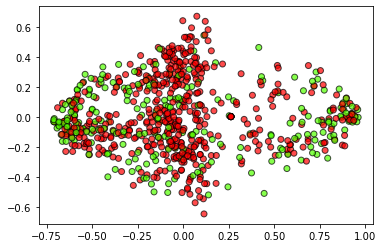

In [100]:
# Build and plot PCA to visualize the balance of the classes in the dataset
pca = PCA(n_components=2)
pca.fit(np.array(X_train_dep))
X_pca_dep = pca.transform(np.array(X_train_dep))
plt.scatter(X_pca_dep[:, 0], X_pca_dep[:, 1], c=y_train_dep, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()
#the PCA plot shows that the red class (diagnosed) is mostly represented 

In [140]:

y_train_dep=y_train_dep.ravel()
log_dep = LogisticRegression().fit(X_train_dep, y_train_dep)

# Predicting the test set results
y_pred_dep = log_wor.predict(X_test_dep)


##TODO: Make sure the dataset is balanced

In [141]:
print("R2 score for dep training data:  ", log_wor.score(X_train_dep, y_train_dep)) 
print("R2 score for dep testing data:  ", log_wor.score(X_test_dep, y_test_dep)) 

#R2 score for dep training data:   0.5923076923076923
#R2 score for dep testing data:   0.5969387755102041

R2 score for dep training data:   0.5923076923076923
R2 score for dep testing data:   0.5969387755102041


#### Worry

In [102]:
"""Predicting the diagnosis on the basis of the representations by means 
of logistic regression """

#x_wor = df_wor_concat #To use full concatinated vectors with 2048 dimensions (before PCA) + normalized with l2
x_wor = response_space_wor #To use vectors with reduced dimensions (after PCA)

#Splitting data into training and testing dataset for anxiety data
X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(x_wor, y_wor_diag, test_size=0.2, random_state=0)


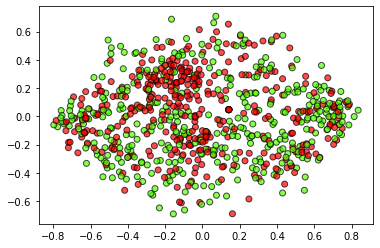

In [103]:
# build and plot PCA to visualize the balance of the classes in the dataset
pca = PCA(n_components=2)
pca.fit(np.array(X_train_wor))
X_pca_wor = pca.transform(np.array(X_train_wor))
plt.scatter(X_pca_wor[:, 0], X_pca_wor[:, 1], c=y_train_wor, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [126]:
y_train_wor=y_train_wor.ravel()

log_wor = LogisticRegression().fit(X_train_wor, y_train_wor)

# Predicting the test set results
y_pred_wor = log_wor.predict(X_test_wor)

In [129]:
print("R2 score for worry training data:  ", log_wor.score(X_train_wor, y_train_wor)) 
print("R2 score for worry testing data:  ", log_wor.score(X_test_wor, y_test_wor))

#R2 score for worry training data:   0.7589743589743589
#R2 score for worry testing data:   0.6581632653061225

R2 score for worry training data:   0.7589743589743589
R2 score for worry testing data:   0.6275510204081632


# Examining optimal number of dimensions
### Using the method described in the article combined with plain linear regression

In [ ]:
"""In practice, this was simply achieved by adding 1, 
then multiplying by 1.3 and finally rounding to the nearest integer 
(e.g., 1, 3, 5, 8, where the next number of dimen- sions to be tested are the first 12; 
in other words ([8 􏰃 1] 􏰍 1.3).
In previous research, we have found this sequence to be valid and computationally efficient"""


In [30]:
#initializing values
n, min_err = 1, np.inf
new_x = df_wor_concat

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)


while n < len(df_wor_concat.columns):
    
    #split data into train and test data
    X_train_wor, X_test_wor, y_train_wor, y_test_wor = train_test_split(new_x, y_wor, test_size=0.2, random_state=0)
    y_train_wor = y_train_wor.flatten() 
    y_test_wor = y_test_wor.flatten()
    
    regr_wor = LinearRegression()
    
    #fit data
    regr_wor.fit(X_train_wor, y_train_wor)
    
    #make prediction 
    y_pred_wor = regr_wor.predict(X_test_wor) 
    
    #test prediction with mean squared error 
    err = mean_squared_error(y_test_wor, y_pred_wor)
    
    #compare err with current min err to then later choose the nbr of dimensions that give minimum mean squared error
    if err < min_err:
        min_err = err
        dimensions = n
        r2 = regr_wor.score(X_test_wor, y_test_wor)
        
    n=round((n+1)*1.3)
    new_x=df_wor_concat.iloc[:,:n] 

print('Nbr of dimensions to use : ', dimensions) #According to this we should use 98 dimensions in the next steps?
print(min_err)
print(r2)

Nbr of dimensions to use :  42
32.19768520074328
0.10949551677885527


In [44]:
"Using the depression data to test how many dimensions to keep"

y_dim = y_dep
dimension, min_error = 0, np.inf
i = 1

# df_wor_concat => To use full concatinated vectors with 2048 dimensions (before PCA)
# response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dim = df_dep_concat.iloc[:,:i]
    X_train_dim, X_test_dim, y_train_dim, y_test_dim = train_test_split(x_dim, y_dim, test_size=0.2, random_state=0)

    regr_dim = LinearRegression()
    
    regr_dim.fit(X_train_dim, y_train_dim)
    y_pred_dim = regr_dim.predict(X_test_dim) 
    
    mse = mean_squared_error(y_test_dim, y_pred_dim)
    
    if mse < min_error: 
        min_error = mse
        dimension = i
        r2 = regr_dim.score(X_test_dim, y_test_dim)
    #print(i, mse)
    i = round((i + 1)*1.3)
    
print('\nNbr of dimensions to use: ', dimension)
print(min_error, r2)


Nbr of dimensions to use:  56
46.62095013955586 0.13605102267736957




# Results examining optimal number of dimensions

#### Depression

Technique | Original dimension | R2 score | MSE | Nbr dimensions
----- | --- | --- | --- | --- 
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.040 | 51.80 | 17
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048	 | 0.136 | 46.62 | 56
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.025 | 6.828 | 74



#### Anxiety

Technique | Original dimension | R2 score | MSE | Nbr dimensions
----- | --- | --- | --- | --- 
**(i+1)*1.3** from article w/ **linReg** | PCA red vec: 512 | 0.131 | 31.42 | 56
**(i+1)*1.3** from article w/ **linReg** | Full concat: 2048 | 0.131 | 31.42 | 98
**(i+1)*1.3** from article w/ **leave 10% CV** | Full concat: 2048 | -0.112 | 7.169 | 56


# Cross validation techniques

## Examining optimal number of dimensions using method described in article combined with leave 10% cross validation

### Depression

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#response_space_dep => To use vectors with reduced dimensions (after PCA)

while i < len(df_dep_concat.columns):
    x_dep_cv = df_dep_concat.iloc[:,:i]
    
    #Options for scoring: 'r2', 'neg_root_mean_squared_error' 
    scores = cross_val_score(reg, x_dep_cv, y_dep, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(min_error, dimension)) #Using dep data => 74 dimensions

### Anxiety

In [ ]:
#Leave 10% out cross validation while testing the number of dimensions that will give the best over all score. 

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()
dimension, min_error = 0, -np.inf
i = 1

#df_wor_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
#response_space_wor => To use vectors with reduced dimensions (after PCA)

while i < len(df_wor_concat.columns):
    x_wor_cv = df_wor_concat.iloc[:,:i]
    
    #Options for scoring: 'r2', 'neg_root_mean_squared_error' 
    scores = cross_val_score(reg, x_wor_cv, y_dep, scoring='r2', cv=cv, n_jobs=-1)
    
    if scores.mean() > min_error:
        min_error = scores.mean()
        dimension = i
        
    i = round((i + 1)*1.3)
    
print("Best score: {} with dimension: {}".format(min_error, dimension)) #Using wor data => 56 dimensions

#### Leave 10% out cross validation on PCA reduced vectors

In [ ]:
#Leave 10% out cross validation using PCA reduced vectors

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

nbr_folds = round(len(responses)*0.1)
cv = KFold(n_splits=nbr_folds, random_state=1, shuffle=True)

reg = LinearRegression()

#df_dep_concat      => To use full concatinated vectors with 2048 dimensions (before PCA)
x_dep_cv = response_space_dep #=> To use vectors with reduced dimensions (after PCA)

#Options for scoring: 'r2', 'neg_root_mean_squared_error' 
scores = cross_val_score(reg, x_dep_cv, y_dep, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
print(scores.mean())

# Visualisation

In [175]:
#import packages
from sklearn.datasets import load_digits
import seaborn as sns
import umap

#%matplotlib inline

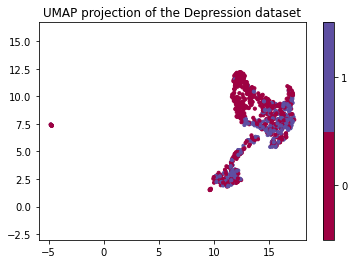

In [176]:
"""Will use umap by: constructing a model, training the model, and then looking at the transformed data"""

reducer = umap.UMAP()

#embedding will have shape (976,2) since umap reduces down to 2d 
embedding = reducer.fit_transform(response_space_dep) #uses vectors with reduced dimensions (after PCA)
#embedding = reducer.fit_transform(df_dep_concat) #uses full concatinated vectors with 2048 dimensions (before PCA)

#plot the embedding as a standard scatterplot and color by the target array
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_dep_diag, cmap='Spectral', s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.title('UMAP projection of the Depression dataset');